In [16]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import torch
from dnn_training.dataset import *
import numpy as np
from dnn_training.trainer import *
import awkward as ak
import matplotlib.pyplot as plt
import scipy.optimize, scipy.stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
device="cuda:1"
model = makeModel()
loss = BinaryLoss()
trial = FixedTrial({
    "dropout" : 0.2,
    "trainingLossType" : "binary",
    "batchSize" : 512,
    "weightSamples" : False,
    "lr" : 1e-3,
})
trainer = Trainer(model.to(device), loss=loss, trial=trial, device=device, log_output="/grid_mnt/data_cms_upgrade/cuisset/supercls/dnn_training/test")
datasets_binary = makeDatasetsTrainVal_fromCache("/grid_mnt/data_cms_upgrade/cuisset/supercls/alessandro_electrons/supercls-v15-sampleDump/superclsDumper_*.root", device_valDataset=device)
datasets_continuous = makeDatasetsTrainVal_fromCache("/grid_mnt/data_cms_upgrade/cuisset/supercls/alessandro_electrons/supercls-v15-sampleDump/superclsDumper_*.root", device_valDataset=device, trainingLossType="continuousAssociationScore")

In [5]:
trainer.reloadModel("/grid_mnt/data_cms_upgrade/cuisset/supercls/dnn_training/hyperparams-v3/236-Apr09_13-04-27/model_lastEpoch_48.pth")

In [6]:
datasets_continuous

{'trainDataset': <torch.utils.data.dataset.StackDataset at 0x7f2f60854a50>,
 'valDataset': {'features': tensor([[ 4.9151e-02, -3.5352e+00,  1.1917e+01,  ...,  2.0669e-01,
            3.5756e+01,  9.5144e-01],
          [ 1.8419e-01,  9.7488e-01,  1.8703e+01,  ...,  1.6640e-01,
            2.9074e+01,  9.6073e-01],
          [ 8.9139e-02, -4.6144e+00,  1.5425e+01,  ...,  7.7751e-02,
            2.3623e+01,  9.4039e-01],
          ...,
          [-1.9143e-01,  1.2265e+00,  2.4703e+00,  ...,  4.4375e-02,
            7.4003e+00,  9.8095e-01],
          [ 3.0321e-02,  3.0368e+00,  1.5284e+00,  ...,  4.8386e-02,
            2.1962e+01,  9.9356e-01],
          [ 2.8014e-03,  1.8716e+00,  4.9680e+00,  ...,  6.1285e-02,
            1.8545e+01,  9.7659e-01]]),
  'genmatching': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'assocScore_training': tensor([1., 1., 1.,  ..., 1., 1., 1.]),
  'seedTracksterBestAssociationScore': tensor([0.0149, 0.0149, 0.0149,  ..., 0.0367, 0.0367, 0.0367]),
  'candidateTr

In [7]:
val_dataset_cpu = {key : tensor.cpu() for key, tensor in datasets_continuous["valDataset"].items()}
val_dataset_gpu = {key : tensor.to(trainer.device) for key, tensor in datasets_continuous["valDataset"].items()}

In [8]:
pred, loss = trainer.val_evaluateModel(val_dataset_gpu)
pred = trainer.loss.switchPredIfNeeded(pred).cpu()

In [9]:
pred

tensor([5.0822e-08, 8.5382e-10, 5.7731e-09,  ..., 0.0000e+00, 4.0291e-08,
        7.7943e-06])

In [11]:
val_dataset = val_dataset_cpu
def superclusteredEnergyForWP(wp:float):
    """ Compute for each event the sum of energy superclustered by the DNN at the given WP """
    return val_dataset["seedEnergy_perEvent"] + torch.scatter_add(torch.zeros(torch.max(val_dataset["eventIndex"])+1, device=val_dataset["eventIndex"].device), 0, val_dataset["eventIndex"], val_dataset["features"][:, featureNames.index("multi_en")]*(pred >= wp))

superclsEnergy = superclusteredEnergyForWP(0.8)
superclsEnergy_ratio = superclsEnergy / val_dataset["caloParticleEnergy_perEvent"]
superclsEnergy_ratio

tensor([1.2242, 1.0672, 1.0293,  ..., 0.9948, 0.9561, 1.1771])

7163

In [20]:
resid

tensor([ 0.2362,  0.0793,  0.0415,  ...,  0.0088, -0.0310,  0.1893])

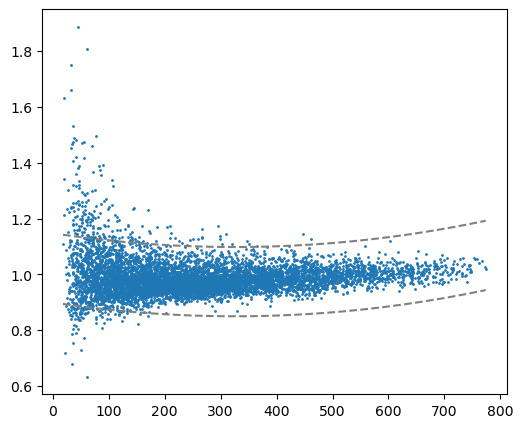

In [22]:
x, y = val_dataset["caloParticleEnergy_perEvent"].numpy(), superclsEnergy_ratio.numpy()
p, cov = np.polyfit(x, y, 2, cov=True) 
t = scipy.stats.t.ppf(0.975, val_dataset["caloParticleEnergy_perEvent"].shape[0] - p.size)    

dof = x.shape[0] - p.size
y_model = np.polyval(p, x) 
resid = y - y_model      
s_err = np.sqrt(np.sum(resid**2) / dof) 
x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = np.polyval(p, x2)
pi = t * s_err * np.sqrt(1 + 1/x.shape[0] + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   

plt.scatter(x, y, s=1)


plt.gca().fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
plt.gca().plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
plt.gca().plot(x2, y2 + pi, "--", color="0.5")


In [42]:
y_sample = np.linspace(0, 2, 1000)

In [45]:
np.broadcast(1., y_sample)

In [54]:
x_E = 800
avg = np.average(y_sample, weights=kde(np.stack(np.broadcast_arrays(x_E, y_sample))))
avg, np.sqrt(np.average((y_sample-avg)**2, weights=kde(np.stack(np.broadcast_arrays(x_E, y_sample)))))

(1.0255469586261234, 0.026483389011071487)

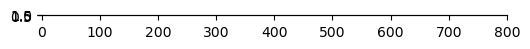

In [31]:
plt.figure()
kde = scipy.stats.gaussian_kde(np.stack([x, y]))
X, Y = np.mgrid[0:800:100j, 0.5:1.6:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)
plt.ylim(0.5, 1.6)
plt.xlim(0, 800)
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[0, 800, 0.5, 1.6])


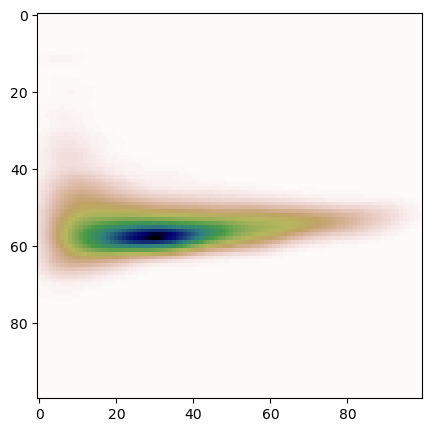

In [33]:
plt.figure()
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)

In [28]:
Z

array([[2.26979936e-023, 1.51264446e-020, 5.71532494e-018, ...,
        2.52425072e-007, 3.86627054e-007, 2.73487935e-006],
       [3.40010231e-023, 2.26023565e-020, 8.51863726e-018, ...,
        3.07015057e-007, 4.35398013e-007, 3.06037952e-006],
       [4.82999718e-023, 3.20273461e-020, 1.20406435e-017, ...,
        3.54365110e-007, 4.65139365e-007, 3.24765019e-006],
       ...,
       [1.15046114e-113, 6.01337680e-111, 1.78204864e-108, ...,
        2.43863172e-100, 2.41836507e-102, 1.36044982e-104],
       [1.00129686e-115, 5.22061489e-113, 1.54324591e-110, ...,
        2.25204031e-102, 2.22773319e-104, 1.24991803e-106],
       [8.26426296e-118, 4.29808771e-115, 1.26736319e-112, ...,
        1.97222528e-104, 1.94605509e-106, 1.08904041e-108]])

In [11]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
val_etas = val_dataset[:]["features"][0][:, 3] # index 3 is multi_eta
val_energies = val_dataset[:]["features"][0][:, 2] # index 2 is multi_en
ens = histedges_equalN(val_energies, 5)
etas = histedges_equalN(torch.abs(val_etas), 4)
ens, etas

(array([  1.50000608,   2.21427965,   3.11312909,   4.44952669,
          7.04064255, 112.21328735]),
 array([1.52112067, 2.28675771, 2.5121839 , 2.68080544, 3.12905979]))

In [10]:
histedges_equalN(val_energies[val_energies > 7], 4)

array([  7.00000334,   8.19011784,   9.98443699,  13.35840893,
       112.21328735])